In [101]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
import pprint
import numpy as np
import seaborn as sns 

In [102]:
# Path to the CSV file
csv_file = './cleaned_merged_course_data.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)


<AxesSubplot:xlabel='Fremmødte', ylabel='Eksamensgennemsnit'>

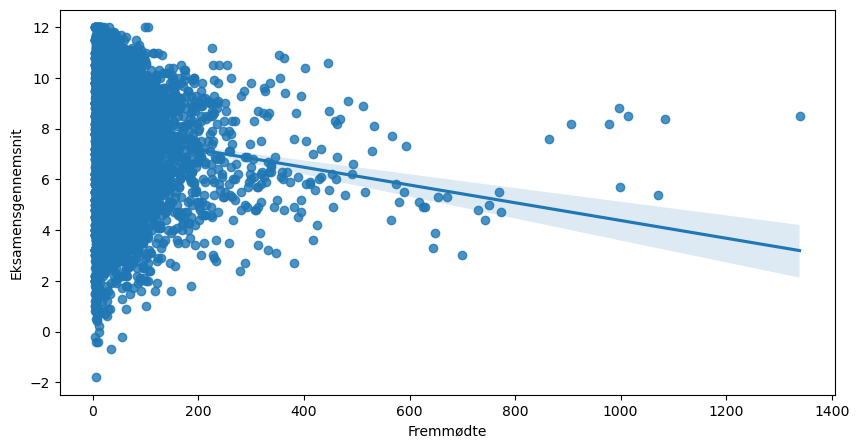

In [103]:
# Convert "Eksamensgennemsnit" to a numeric type
df['Eksamensgennemsnit'] = pd.to_numeric(df['Eksamensgennemsnit'].str.replace(',', '.'), errors='coerce')

# Ensure "Fremmødte" is numeric (if it isn't already)
df['Fremmødte'] = pd.to_numeric(df['Fremmødte'], errors='coerce')

fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(y='Eksamensgennemsnit', x='Fremmødte', data=df)

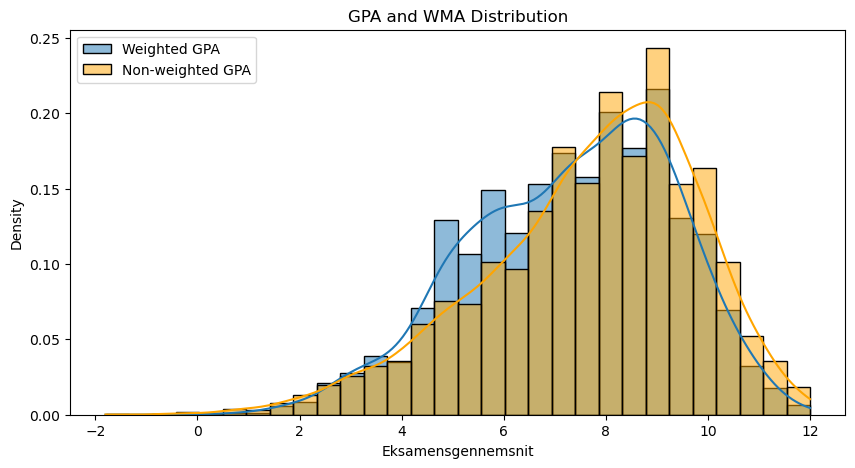

In [104]:
# Ensure 'Eksamensgennemsnit' is treated as a string first, then convert
df['Eksamensgennemsnit'] = df['Eksamensgennemsnit'].astype(str).str.replace(',', '.').astype(float)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the weighted GPA distribution
sns.histplot(data=df, x='Eksamensgennemsnit', weights='Fremmødte', kde=True, ax=ax, bins=30, stat='density', label='Weighted GPA')

# Plot the non-weighted GPA distribution
sns.histplot(data=df, x='Eksamensgennemsnit', kde=True, ax=ax, color='orange', bins=30, stat='density', label='Non-weighted GPA')
# Add legend and title
plt.legend()
ax.set_title("GPA and WMA Distribution")

# Show the plot
plt.show()

In [105]:
# Load the Excel file
clean_merged_df = pd.read_csv('./cleaned_merged_course_data.csv')

# Ensure the necessary columns are numeric
clean_merged_df['Fremmødte'] = pd.to_numeric(clean_merged_df['Fremmødte'], errors='coerce')
clean_merged_df['Eksamensgennemsnit'] = pd.to_numeric(clean_merged_df['Eksamensgennemsnit'], errors='coerce')

# Group by 'Kursustype' and calculate weighted and unweighted averages
summary_df = cleaned_df.groupby('Kursustype').apply(
    lambda x: pd.Series({
        'Count': x.shape[0],
        'Weighted GPA': (x['Eksamensgennemsnit'] * x['Fremmødte']).sum() / x['Fremmødte'].sum(),
        'Unweighted GPA': x['Eksamensgennemsnit'].mean()
    })
).reset_index()

# Display the summary table
summary_df

,Kursustype,Count,Weighted GPA,Unweighted GPA
0,Bachelor,1876.0,7.016824,7.187367
1,"Bachelor, Diplomingeniør",126.0,6.709844,6.609524
2,Deltidsmaster,179.0,8.939205,8.850279
3,Diplomingeniør,857.0,5.185486,5.860210
4,Kandidat,3898.0,8.261802,8.308825
5,"Kandidat, Bachelor",103.0,7.435888,7.446602
6,"Kandidat, Bachelor, Diplomingeniør",6.0,5.682218,6.050000
7,"Kandidat, Diplomingeniør",90.0,7.954228,7.303333
8,Ph.d.,56.0,9.443292,9.192857


In [106]:
clean_merged_df = pd.read_csv('./cleaned_merged_course_data.csv')

# Ensure the necessary columns are numeric
clean_merged_df['Fremmødte'] = pd.to_numeric(clean_merged_df['Fremmødte'], errors='coerce')
clean_merged_df['Eksamensgennemsnit'] = clean_merged_df['Eksamensgennemsnit'].astype(str).str.replace(',', '.')
clean_merged_df['Eksamensgennemsnit'] = pd.to_numeric(clean_merged_df['Eksamensgennemsnit'], errors='coerce')

# Calculate weighted and unweighted averages for 'Anden'
anden_rows = cleaned_df[cleaned_df['Evalueringsform'] == 'Anden']
if not anden_rows.empty:
    weighted_avg = (anden_rows['Eksamensgennemsnit'] * anden_rows['Fremmødte']).sum() / anden_rows['Fremmødte'].sum()
    unweighted_avg = anden_rows['Eksamensgennemsnit'].mean()

# Ensure 'Anden' is included in the summary output
summary_df = cleaned_df.groupby('Evalueringsform').apply(
    lambda x: pd.Series({
        'Count': x.shape[0],
        'Weighted Eksamensgennemsnit': (x['Eksamensgennemsnit'] * x['Fremmødte']).sum() / x['Fremmødte'].sum(),
        'Unweighted Eksamensgennemsnit': x['Eksamensgennemsnit'].mean()
    })
).reset_index()

# Display the summary table
summary_df

,Evalueringsform,Count,Weighted Eksamensgennemsnit,Unweighted Eksamensgennemsnit
0,Anden,2.0,7.933526,8.000000
1,Mundtlig eksamen,450.0,8.455872,8.467333
2,Portfolio,5405.0,7.675259,8.081998
3,Skriftlig eksamen,1246.0,5.849813,5.712761
4,Skriftlig og mundtlig eksamen,88.0,6.770776,7.480682


In [110]:
clean_merged_df = pd.read_csv('./cleaned_merged_course_data.csv')

# Ensure the necessary columns are numeric
clean_merged_df['Fremmødte'] = pd.to_numeric(clean_merged_df['Fremmødte'], errors='coerce')
clean_merged_df['Eksamensgennemsnit'] = clean_merged_df['Eksamensgennemsnit'].astype(str).str.replace(',', '.')
clean_merged_df['Eksamensgennemsnit'] = pd.to_numeric(clean_merged_df['Eksamensgennemsnit'], errors='coerce')

# Drop rows with NaN values in the necessary columns
cleaned_df = clean_merged_df.dropna(subset=['Fremmødte', 'Eksamensgennemsnit', 'forudsætninger'])

# Calculate weighted and unweighted averages, and count for each Hjælpemidler
summary_df = cleaned_df.groupby('forudsætninger').apply(
    lambda x: pd.Series({
        'Count': x.shape[0],  # Count of occurrences
        'Weighted Eksamensgennemsnit': (x['Eksamensgennemsnit'] * x['Fremmødte']).sum() / x['Fremmødte'].sum(),
        'Unweighted Eksamensgennemsnit': x['Eksamensgennemsnit'].mean()
    })
).reset_index()

# Display the summary table
summary_df

,forudsætninger,Count,Weighted Eksamensgennemsnit,Unweighted Eksamensgennemsnit
0,Ja,5585.0,7.504585,7.797690
1,Nej,1606.0,6.867930,7.307472


In [111]:
clean_merged_df = pd.read_csv('./cleaned_merged_course_data.csv')

# Ensure the necessary columns are numeric
clean_merged_df['Fremmødte'] = pd.to_numeric(clean_merged_df['Fremmødte'], errors='coerce')
clean_merged_df['Eksamensgennemsnit'] = clean_merged_df['Eksamensgennemsnit'].astype(str).str.replace(',', '.')
clean_merged_df['Eksamensgennemsnit'] = pd.to_numeric(clean_merged_df['Eksamensgennemsnit'], errors='coerce')

# Drop rows with NaN values in the necessary columns
cleaned_df = clean_merged_df.dropna(subset=['Fremmødte', 'Eksamensgennemsnit', 'Hjælpemidler'])

# Calculate weighted and unweighted averages, and count for each Hjælpemidler
summary_df = cleaned_df.groupby('Hjælpemidler').apply(
    lambda x: pd.Series({
        'Count': x.shape[0],  # Count of occurrences
        'Weighted Eksamensgennemsnit': (x['Eksamensgennemsnit'] * x['Fremmødte']).sum() / x['Fremmødte'].sum(),
        'Unweighted Eksamensgennemsnit': x['Eksamensgennemsnit'].mean()
    })
).reset_index()

# Display the summary table
summary_df

,Hjælpemidler,Count,Weighted Eksamensgennemsnit,Unweighted Eksamensgennemsnit
0,Ikke tilladt,972.0,7.492445,7.958333
1,Tilladt,6219.0,7.307642,7.645988


In [113]:
clean_merged_df = pd.read_csv('./cleaned_merged_course_data.csv')

# Ensure the necessary columns are numeric
clean_merged_df['Fremmødte'] = pd.to_numeric(clean_merged_df['Fremmødte'], errors='coerce')
clean_merged_df['Eksamensgennemsnit'] = clean_merged_df['Eksamensgennemsnit'].astype(str).str.replace(',', '.')
clean_merged_df['Eksamensgennemsnit'] = pd.to_numeric(clean_merged_df['Eksamensgennemsnit'], errors='coerce')

# Drop rows with NaN values in the necessary columns
cleaned_df = clean_merged_df.dropna(subset=['Fremmødte', 'Eksamensgennemsnit', 'Ekstern samarbejdsinstitution'])

# Calculate weighted and unweighted averages, and count for each Hjælpemidler
summary_df = cleaned_df.groupby('Ekstern samarbejdsinstitution').apply(
    lambda x: pd.Series({
        'Count': x.shape[0],  # Count of occurrences
        'Weighted Eksamensgennemsnit': (x['Eksamensgennemsnit'] * x['Fremmødte']).sum() / x['Fremmødte'].sum(),
        'Unweighted Eksamensgennemsnit': x['Eksamensgennemsnit'].mean()
    })
).reset_index()

# Display the summary table
summary_df

,Ekstern samarbejdsinstitution,Count,Weighted Eksamensgennemsnit,Unweighted Eksamensgennemsnit
0,Ja,231.0,7.669832,8.338095
1,Nej,6960.0,7.319927,7.666638
